In [1]:
# Fill in your name using the format below and student ID number
your_name = "SMIT, GIJS"
student_id = "0905883"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi GIJS, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [7]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [8]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [9]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [10]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [11]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [12]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

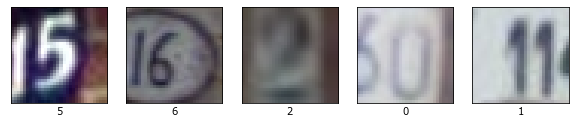

In [13]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
        base_dir -- Directory where the models are stored
        name -- Name of the model, e.g. 'question_1_1'
        extension -- the file extension
    """
    try:
        # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
        # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
        model -- the model to be saved
        base_dir -- Directory where the models should be stored
        name -- Name of the model, e.g. 'question_1_1'
        extension -- the file extension
    """
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    # If model > 100MB, store the weights and architecture only.
    if size > 100*1024*1024:
        print("Model larger than 100MB, storing weights only.")
        model.save_weights(path)
        model_json = model.to_json()
        with open(os.path.join(base_dir, name+".json"), "w") as json_file:
            json_file.write(model_json)

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

In [15]:
# Toy usage example
# Remove before submission
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# First build and store
# run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, train=True, epochs=3, batch_size=32)

Loading model from file
Success!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30730     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233294  0.190372  2.233091      0.190974
max  2.245526  0.190907  2.233174      0.190974


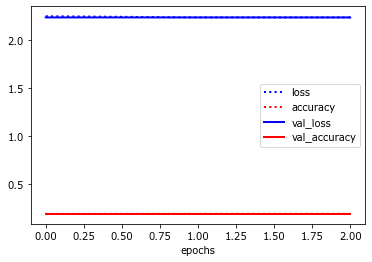

In [16]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

In [17]:
# import extra utilities
import math
import random
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

In [18]:
# set seeds for reproducible results
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Loading model from file
Success!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1152)              3540096   
_________________________________________________________________
dense_3 (Dense)              (None, 576)               664128    
_________________________________________________________________
dense_4 (Dense)              (None, 288)               166176    
_________________________________________________________________
dense_5 (Dense)              (None, 144)               41616     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1450      
Total params: 4,413,466
Trainable params: 4,413,466
Non-trainable params: 0
___________

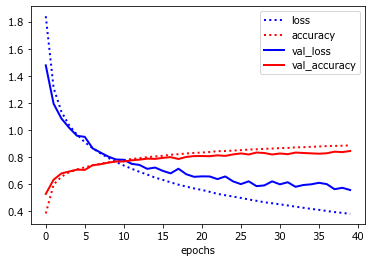

In [19]:
def build_model_1_1():
    # initialize model
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    
    # dense layers (each half the size of its predecessor)
    model.add(layers.Dense(1152, activation='relu', kernel_initializer='he_uniform'))  # layer 1
    model.add(layers.Dense(576, activation='relu', kernel_initializer='he_uniform'))  # layer 2
    model.add(layers.Dense(288, activation='relu', kernel_initializer='he_uniform'))  # layer 3
    model.add(layers.Dense(144, activation='relu', kernel_initializer='he_uniform'))  # layer 4
    
    # final classification layer
    model.add(layers.Dense(10, activation='softmax'))
    
    # compile model
    adam = optimizers.Adam(learning_rate=1.25e-5)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=False, epochs=40, batch_size=12)

In [20]:
answer_q_1_1 = """
Our network consists of 4 layers where each subsequent layer has half as many nodes: 1152-576-288-144.
We experimented a lot to find an optimal design: a too narrow layer will drop info and a too wide 
layer will overfit. The network was able to achieve a decent validation accuracy of 84.5% without
overfitting too much. We used Adam as optimizer as it performed better and converged the fastest.
Adam worked best in combination with a learning rate of 1.25e-5, a batch size of 12, and 40 epochs.
"""

print("Answer is {} characters long".format(len(answer_q_1_1)))

Answer is 499 characters long


### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [21]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

In [22]:
# helper function to standardize data
def standardize(train_data, valid_data):
    train_mean = np.mean(train_data.flatten())
    train_sigma = np.std(train_data.flatten())
    X_train = (train_data - train_mean) / train_sigma
    X_valid = (valid_data - train_mean) / train_sigma
    
    return X_train, X_valid

In [23]:
# helper function to increase contrast
def increase_contrast(X, verbose=False):
    min_val = np.min(X)
    max_val = np.max(X)
    X = np.clip(X, min_val, max_val)
    X = ((X - min_val) / (max_val - min_val))
    
    return X

In [24]:
# function to plot gray images
def plot_gray_image(X, verbose=False, processed=False):
    plt.figure(figsize=(3, 3))
    plt.imshow(X.squeeze(), cmap='gray', vmin=0, vmax=1)
    if processed:
        plt.title('Example of pre-processed image')
    else:
        plt.title('Example of original image')
    plt.show()
    
    if verbose:
        print(f'Pixel max of image:  {round(np.max(X.squeeze()), 3)}')
        print(f'Pixel min of image:  {round(np.min(X.squeeze()), 3)}')
        print(f'Pixel mean of image: {round(np.mean(X.squeeze()), 3)}')
        print(f'Pixel std of image:  {round(np.std(X.squeeze()), 3)}')

In [25]:
# convert images to grayscale
X_train_gray, X_val_gray = rgb2gray(X_train), rgb2gray(X_val)  # convert to grayscale

# add contrast to images
X_train_contrast = np.array([increase_contrast(img) for img in X_train_gray])
X_val_contrast = np.array([increase_contrast(img) for img in X_val_gray])

# standardize (if needed)
STANDARDIZE = False
if STANDARDIZE:
    X_train_contrast, X_val_contrast = standardize(X_train_contrast, X_val_contrast)  # standardize input values

# combine pre-processed data
preprocessed_split = X_train_contrast, X_val_contrast, y_train, y_val

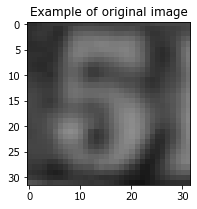

Pixel max of image:  0.553
Pixel min of image:  0.072
Pixel mean of image: 0.319
Pixel std of image:  0.104


In [26]:
# show example of non pre-processed data
plot_gray_image(np.copy(X_val_gray[38]), verbose=True, processed=False)

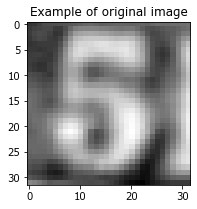

Pixel max of image:  1.0
Pixel min of image:  0.0
Pixel mean of image: 0.514
Pixel std of image:  0.216


In [27]:
# show example of pre-processed data
plot_gray_image(np.copy(X_val_contrast[38]), verbose=True, processed=False)

Loading model from file
Success!
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1152)              1180800   
_________________________________________________________________
dense_8 (Dense)              (None, 576)               664128    
_________________________________________________________________
dense_9 (Dense)              (None, 288)               166176    
_________________________________________________________________
dense_10 (Dense)             (None, 144)               41616     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1450      
Total params: 2,054,170
Trainable params: 2,054,170
Non-trainable params: 0
___________

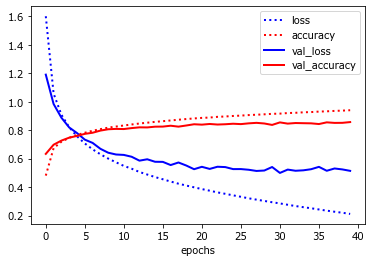

In [28]:
# Adjusted model
def build_model_1_2():
    # initialize model
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    
    # dense layers (each half the size of its predecessor)
    model.add(layers.Dense(1152, activation='relu', kernel_initializer='he_uniform'))  # layer 1
    model.add(layers.Dense(576, activation='relu', kernel_initializer='he_uniform'))  # layer 2
    model.add(layers.Dense(288, activation='relu', kernel_initializer='he_uniform'))  # layer 3
    model.add(layers.Dense(144, activation='relu', kernel_initializer='he_uniform'))  # layer 4
    
    # final classification layer
    model.add(layers.Dense(10, activation='softmax'))
    
    # compile model
    adam = optimizers.Adam(learning_rate=1.25e-5)
    model.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=40, batch_size=12)

In [29]:
answer_q_1_2 = """
We converted the images to grayscale and increased the contrast to make the digits more distinguishable.
Applying standardization (zero mean and unit variance) resulted in significantly more overfitting so we
left it out. The same model from 1.1 now achieved a validation accuracy of 85.7% which is 1.2% better.
The overfitting is now much larger compared to 1.1. We conclude that dense networks cannot distinguish
different color channels so they can learn better features from grayscale images.
"""

print("Answer is {} characters long".format(len(answer_q_1_2)))

Answer is 498 characters long


### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

In [30]:
# focal loss implementation for keras
import tensorflow.keras.backend as K

def categorical_focal_loss(gamma=2., alpha=.25):
    """ https://github.com/umbertogriffo/focal-loss-keras """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

Loading model from file
Success!
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1024)              0         
_________________________________________________________________
block1_dense (Dense)         (None, 1152)              1180800   
_________________________________________________________________
block1_batchnorm (BatchNorma (None, 1152)              4608      
_________________________________________________________________
block1_dropout (Dropout)     (None, 1152)              0         
_________________________________________________________________
block2_dense (Dense)         (None, 576)               664128    
_________________________________________________________________
block2_batchnorm (BatchNorma (None, 576)               2304      
_________________________________________________________________
block2_dropout (Dropo

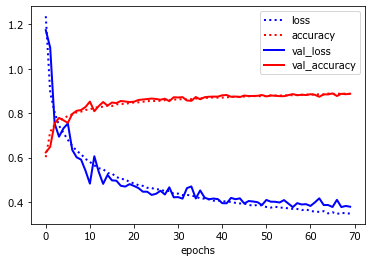

In [31]:
def build_model_1_3():
    # initialize model
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32, 32, 1)))
    
    # block 01
    model.add(layers.Dense(1152, activation='relu', kernel_initializer='he_uniform', name='block1_dense'))
    model.add(layers.BatchNormalization(name='block1_batchnorm'))
    model.add(layers.Dropout(0.2, name='block1_dropout'))
    
    # block 02
    model.add(layers.Dense(576, activation='relu', kernel_initializer='he_uniform', name='block2_dense'))
    model.add(layers.BatchNormalization(name='block2_batchnorm'))
    model.add(layers.Dropout(0.2, name='block2_dropout'))
    
    # block 03
    model.add(layers.Dense(288, activation='relu', kernel_initializer='he_uniform', name='block3_dense'))
    model.add(layers.BatchNormalization(name='block3_batchnorm'))
    model.add(layers.Dropout(0.2, name='block3_dropout'))
    
    # block 04
    model.add(layers.Dense(144, activation='relu', kernel_initializer='he_uniform', name='block4_dense'))
    model.add(layers.BatchNormalization(name='block4_batchnorm'))
    model.add(layers.Dropout(0.2, name='block4_dropout'))
    
    # final classification layer
    model.add(layers.Dense(10, activation='softmax', name='block5_fc'))
    
    # compile model
    adam = optimizers.Adam(learning_rate=1.25e-3)
    model.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=70, batch_size=96)

In [32]:
answer_q_1_3 = """
We regularized the model by adding batchnorm and dropout after each dense layer. L1 and L2 regularization 
gave no noticable improvements in combination with batchnorm and dropout so we left L1 and L2 out. The 
regularized model achieved a validation accuracy of 88.7%, which is a 3.0% improvement over 1.2. Also,
the model is not overfitting anymore. Regularization has decreased the gap between validation and 
train accuracy and it has improved the overall performance of the dense network.
"""
print("Answer is {} characters long".format(len(answer_q_1_3)))

Answer is 495 characters long


## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv (Conv2D)         (None, 32, 32, 64)        640       
_________________________________________________________________
block1_batchnorm (BatchNorma (None, 32, 32, 64)        256       
_________________________________________________________________
block1_dropout (Dropout)     (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv (Conv2D)         (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_batchnorm (BatchNorma (None, 32, 32, 128)       512       
_________________________________________________________________
block2_dropout (Dropout)     (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv (Conv2D) 

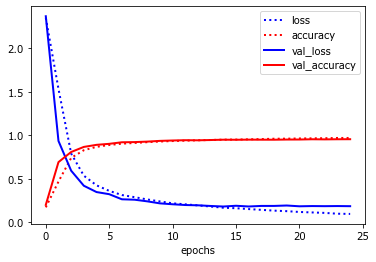

In [33]:
def build_model_2_1():
    # initialize model
    model = models.Sequential()
    
    # block 1
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(32, 32, 1), name='block1_conv'))
    model.add(layers.BatchNormalization(name='block1_batchnorm'))
    model.add(layers.Dropout(0.2, name='block1_dropout'))
    
    # block 2
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block2_conv'))
    model.add(layers.BatchNormalization(name='block2_batchnorm'))
    model.add(layers.Dropout(0.2, name='block2_dropout'))
    
    # block 3
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block3_conv'))
    model.add(layers.BatchNormalization(name='block3_batchnorm'))
    model.add(layers.Dropout(0.2, name='block3_dropout'))
    
    # block 4 (with max pooling)
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block4_conv'))
    model.add(layers.BatchNormalization(name='block4_batchnorm'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, name='block4_pooling'))
    model.add(layers.Dropout(0.2, name='block4_dropout'))
    
    # block 5
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block5_conv'))
    model.add(layers.BatchNormalization(name='block5_batchnorm'))
    model.add(layers.Dropout(0.2, name='block5_dropout'))
    
    # block 6
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block6_conv'))
    model.add(layers.BatchNormalization(name='block6_batchnorm'))
    model.add(layers.Dropout(0.2, name='block6_dropout'))
    
    # block 7 (with max pooling)
    model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block7_conv'))
    model.add(layers.BatchNormalization(name='block7_batchnorm'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, name='block7_pooling'))
    model.add(layers.Dropout(0.2, name='block7_dropout'))
    
    # block 8
    model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block8_conv'))
    model.add(layers.BatchNormalization(name='block8_batchnorm'))
    model.add(layers.Dropout(0.2, name='block8_dropout'))
    
    # block 9 (with max pooling)
    model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block9_conv'))
    model.add(layers.BatchNormalization(name='block9_batchnorm'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, name='block9_pooling'))
    model.add(layers.Dropout(0.2, name='block9_dropout'))
    
    # block 10
    model.add(layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block10_conv'))
    model.add(layers.BatchNormalization(name='block10_batchnorm'))
    model.add(layers.Dropout(0.2, name='block10_dropout'))

    # block 11  
    model.add(layers.Conv2D(2048, (1,1), padding='same', activation='relu', kernel_initializer='he_uniform', name='block11_conv'))
    model.add(layers.Dropout(0.2, name='block11_dropout'))
    
    # block 12 (with max pooling)
    model.add(layers.Conv2D(256, (1,1), padding='same', activation='relu', kernel_initializer='he_uniform', name='block12_conv'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, name='block12_pooling'))
    model.add(layers.Dropout(0.2, name='block12_dropout'))

    # block 13 (with max pooling)
    model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', name='block13_conv'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, name='block13_pooling'))
    model.add(layers.Dropout(0.2, name='block13_dropout'))

    # final classification block
    model.add(layers.Flatten(name='block14_flatten'))
    model.add(layers.Dense(10, activation='softmax', name='block14_fc'))
    
    # compile model
    adam = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

BATCH_SIZE = 64

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=25, batch_size=BATCH_SIZE)

In [34]:
answer_q_2_1 = """
We implemented a network inspired by the SimpleNet architecture (HasanPour et al., 2016). SimpleNet 
is a relatively simple architecture that can outperform deeper and more complex architectures (e.g. on
CIFAR-10) and it has a good tradeoff between the computation efficiency and accuracy. SimpleNet consists
of typical building blocks that contains a conv, batchnorm, and dropout layer. We adjusted the ordering
in each block such that batchnorm was applied after each conv layer (instead of before). We trained the
model for 25 epochs using Adam as optimzer. The trained model is slightly overfitting. This is done on
purpose so that the model is still able to learn more by using data augmentation. The model achieved
a validation accuracy of 95.7% which is decent for such a small network.
""" 

print("Answer is {} characters long".format(len(answer_q_2_1)))

Answer is 795 characters long


### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

In [35]:
# random cutout function
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [36]:
# inverse image function
def get_inverse(p=0.5):
    def inverser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        else:
            a = np.clip(input_img, 0.0, 1.0)
            c = np.ones(shape=a.shape)
            input_img = c - a

        return input_img

    return inverser

In [37]:
# data augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8, 
    width_shift_range=0.0,
    height_shift_range=0.125, 
    brightness_range=None,
    channel_shift_range=0.25,
    shear_range=30.0, 
    zoom_range=0.0,
    fill_mode='nearest', 
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=get_inverse(p=0.5))  # try this out

train_generator = tf.keras.preprocessing.image.NumpyArrayIterator(
    X_train_contrast, 
    y=y_train, 
    image_data_generator=train_datagen, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

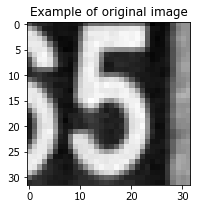

In [38]:
# example of original image
inverser = get_inverse(p=0.0)
plot_gray_image(inverser(np.copy(X_train_contrast[1])), processed=False)

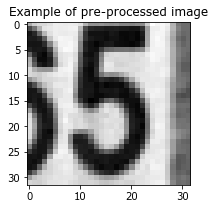

In [39]:
# example of inversed image
inverser = get_inverse(p=1.0)
plot_gray_image(inverser(np.copy(X_train_contrast[1])), processed=True)

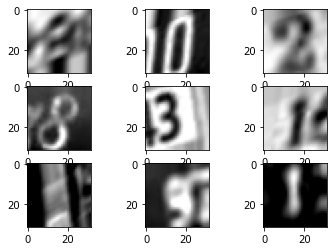

In [40]:
# example of augmentations
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# load the image
it = train_datagen.flow(X_train_contrast, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    
    # convert to unsigned integers for viewing
    image = np.copy(batch[0].squeeze())
    image = image * 255.
    image = image.astype('uint8')
    plt.imshow(image, cmap='gray')

plt.show()

Loading model from file
Success!
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv (Conv2D)         (None, 32, 32, 64)        640       
_________________________________________________________________
block1_batchnorm (BatchNorma (None, 32, 32, 64)        256       
_________________________________________________________________
block1_dropout (Dropout)     (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv (Conv2D)         (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_batchnorm (BatchNorma (None, 32, 32, 128)       512       
_________________________________________________________________
block2_dropout (Dropout)     (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv (Conv2D) 

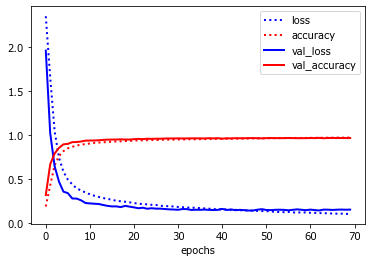

In [41]:
# Note that we build the same untrained model as in question 2.1 but store the trained 
# version as model_2_2. Change attributes as needed to run on augmented data

# manually set steps per epoch
batch_size = BATCH_SIZE
num_samples = X_train_contrast.shape[0]
train_steps = math.ceil(num_samples / batch_size)

augmented_split = train_generator, X_val_contrast, y_val

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=False, generator=True, epochs=70, batch_size=None, steps_per_epoch=train_steps)

In [42]:
answer_q_2_2 = """
The augmentations we implemented are small rotations, heigh shifts, channel shifts, and shears. Larger
rotations and shifts would destroy too much information. We did not implement width shifts as some images
contain multiple digits located next to the center digit. As the images are grayscale we also implemented
a custom augmentation function that inverses the black and white values in images. Using the
augmentations we achieved a validation accuracy of 96.6% which is an 0.9% improvement.
"""

print("Answer is {} characters long".format(len(answer_q_2_2)))

Answer is 496 characters long


## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [43]:
# pre-process test data
X_test_gray, X_test_gray = rgb2gray(X_test), rgb2gray(X_test)  # convert to grayscale

# add contrast to images
X_test_contrast = np.array([increase_contrast(img) for img in X_test_gray])

# standardize (if needed)
if STANDARDIZE:
    _, X_test_contrast = standardize(X_test_contrast, X_test_contrast)  # standardize input values

In [44]:
from sklearn.metrics import accuracy_score
from tensorflow.keras import metrics

# evaluate model on test set
model = load_model_from_file(base_dir, "model_2_2")
preds = model.predict(X_test_contrast, verbose=1)
score = float(np.mean(metrics.categorical_accuracy(y_test, preds)))
print(f'Achieved an accuracy of {round(score, 4)} on the test set')

19858/19858 [==============================] - 9s 433us/sample
Achieved an accuracy of 0.9639 on the test set


In [45]:
# predict multiple times using augmentations
test_generator = tf.keras.preprocessing.image.NumpyArrayIterator(
    X_test_contrast, 
    y=y_test, 
    image_data_generator=train_datagen,
    batch_size=128, 
    shuffle=False,
    seed=42)

num_samples = X_test_contrast.shape[0]
y_pred_list = []

# make multiple predictions
num_iterations = 30
for i, pred in enumerate(range(num_iterations)):
    if (i + 1) % 10 == 0:
        y_pred = model.predict_generator(test_generator, steps=math.ceil(num_samples/128), verbose=1)
        accuracy = float(np.mean(metrics.categorical_accuracy(y_test, y_pred)))
        y_pred_list.append(y_pred)
        print(f'Finished predicting round {str(i + 1).zfill(2)}/{str(num_iterations).zfill(2)}')
    else:
        y_pred = model.predict_generator(test_generator, steps=math.ceil(num_samples/128), verbose=0)
        accuracy = float(np.mean(metrics.categorical_accuracy(y_test, y_pred)))
        y_pred_list.append(y_pred)

y_pred_mean = np.sum(y_pred_list, axis=0)
y_pred_mean = y_pred_mean / len(y_pred_list)

score = float(np.mean(metrics.categorical_accuracy(y_test, y_pred_mean)))
print(f'Achieved an accuracy of {round(score, 6)} on the test set')

Instructions for updating:
Please use Model.predict, which supports generators.
156/156 [==============================] - 5s 35ms/step
Finished predicting round 10/30
156/156 [==============================] - 6s 36ms/step
Finished predicting round 20/30
156/156 [==============================] - 6s 39ms/step
Finished predicting round 30/30
Achieved an accuracy of 0.966059 on the test set


In [46]:
# save test accuracy 
print(f'Accuracy on test set (using augmentations): {round(score, 6)}')
test_accuracy_3_1 = 0.966059

Accuracy on test set (using augmentations): 0.966059


In [47]:
from sklearn.metrics import confusion_matrix

labels_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

def plot_confusion_matrix():
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_mean, axis=1))
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(labels_list, rotation=45, ha="right")
    ax.set_yticklabels(labels_list)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")
        
    plt.show()

def plot_misclassifications():
    # Visualize the (first five) misclassifications, together with the predicted and actual class
    class_index = 1
    y_test_max = np.argmax(y_test, axis=1)
    indices = np.argwhere(y_test_max == class_index)
    indices = [i[0] for i in indices]
    X_test_class = X_test[indices]
    y_test_class = np.argmax(y_test, axis=1)[indices]
    y_pred_class = np.argmax(y_pred_mean, axis=1)[indices]

    misclassified_samples = np.argwhere(y_pred_class != class_index)
    misclassified_samples = [i[0] for i in misclassified_samples]
    num_images = 8
    
    
    fig, axes = plt.subplots(1, num_images,  figsize=(12, 6))
    for nr, i in zip([i for i in range(num_images)], misclassified_samples[:num_images]):
        axes[nr].imshow(X_test_class[i])
        axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (labels_list[y_pred_class[i]], labels_list[y_test_class[i]]))
        axes[nr].set_xticks(()), axes[nr].set_yticks(())

    plt.show()

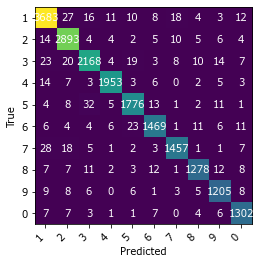

In [48]:
# show the confusion matrix
plot_confusion_matrix()

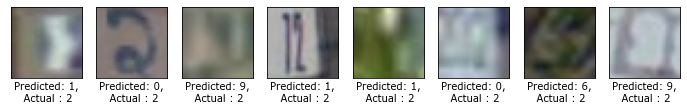

In [49]:
# show some wrong classifications
plot_misclassifications()

In [50]:
answer_q_3_1 = """
The accuracy of the model on the test data is 96.4%. It is possible to get a small accuracy boost
applying the same augmentations from training on the test set and averaging multiple predictions.
This way we increased the accuracy to 96.6% which is an 0.2% improvement. Note that this method
does not causes any data leakage because we only use the test images, not the labels. This is
quite a good accuracy compared to state-of-the-art benchmark that typically reach between
96% to 99% accuracy.

According to the confusion matrix the classes 1, 2 and 7 are often confused and also digits
3, 5, and 9. These digits are quite similar in appearence. We plotted misclassifications of
class 2. It appears that most of the errors are made on images that are unclear, noisy, or
have multiple digits.
"""

print("Answer is {} characters long".format(len(answer_q_3_1)))

Answer is 796 characters long


### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [51]:
# load and summarize model
model = load_model_from_file(base_dir, "model_2_2")

# prepare image and activations
img_tensor = np.copy(X_test_contrast[0])  # first image from test set
img_tensor = np.expand_dims(img_tensor, axis=0) 
layer_outputs = [layer.output for layer in model.layers[:-1]]  # extracts the outputs of the layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)  # return the activations
activations = activation_model.predict(img_tensor)  # one array per layer activation

In [52]:
# get layer names
layer_names = [l.name for l in model.layers]

# plot conv layer names
for e, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        print(e, layer.name)

0 block1_conv
3 block2_conv
6 block3_conv
9 block4_conv
13 block5_conv
16 block6_conv
19 block7_conv
23 block8_conv
26 block9_conv
30 block10_conv
33 block11_conv
35 block12_conv
38 block13_conv


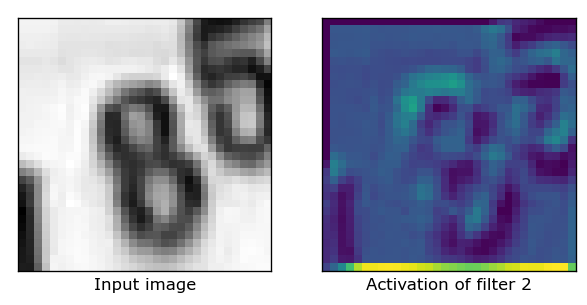

In [53]:
# example of a filter
plt.rcParams['figure.dpi'] = 120
first_layer_activation = activations[0]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_tensor[0].squeeze(), cmap='gray')
ax2.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 2');

In [54]:
def show_filters(layer_index, activations):
    start = layer_index
    end = layer_index + 1
    images_per_row = 16
    
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

C:\Users\GijsSmit\Miniconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


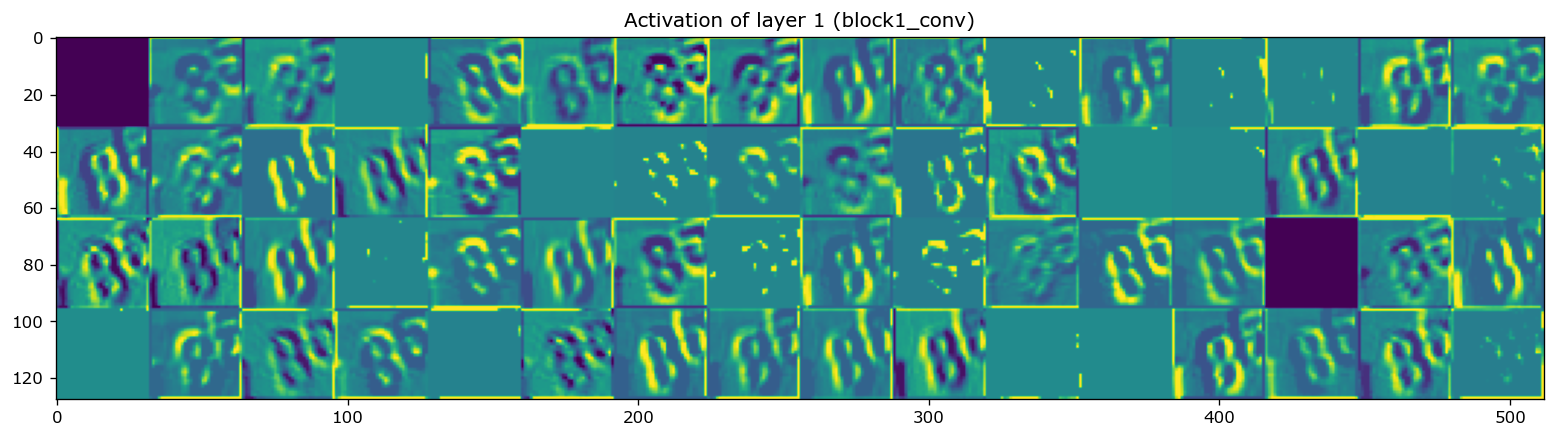

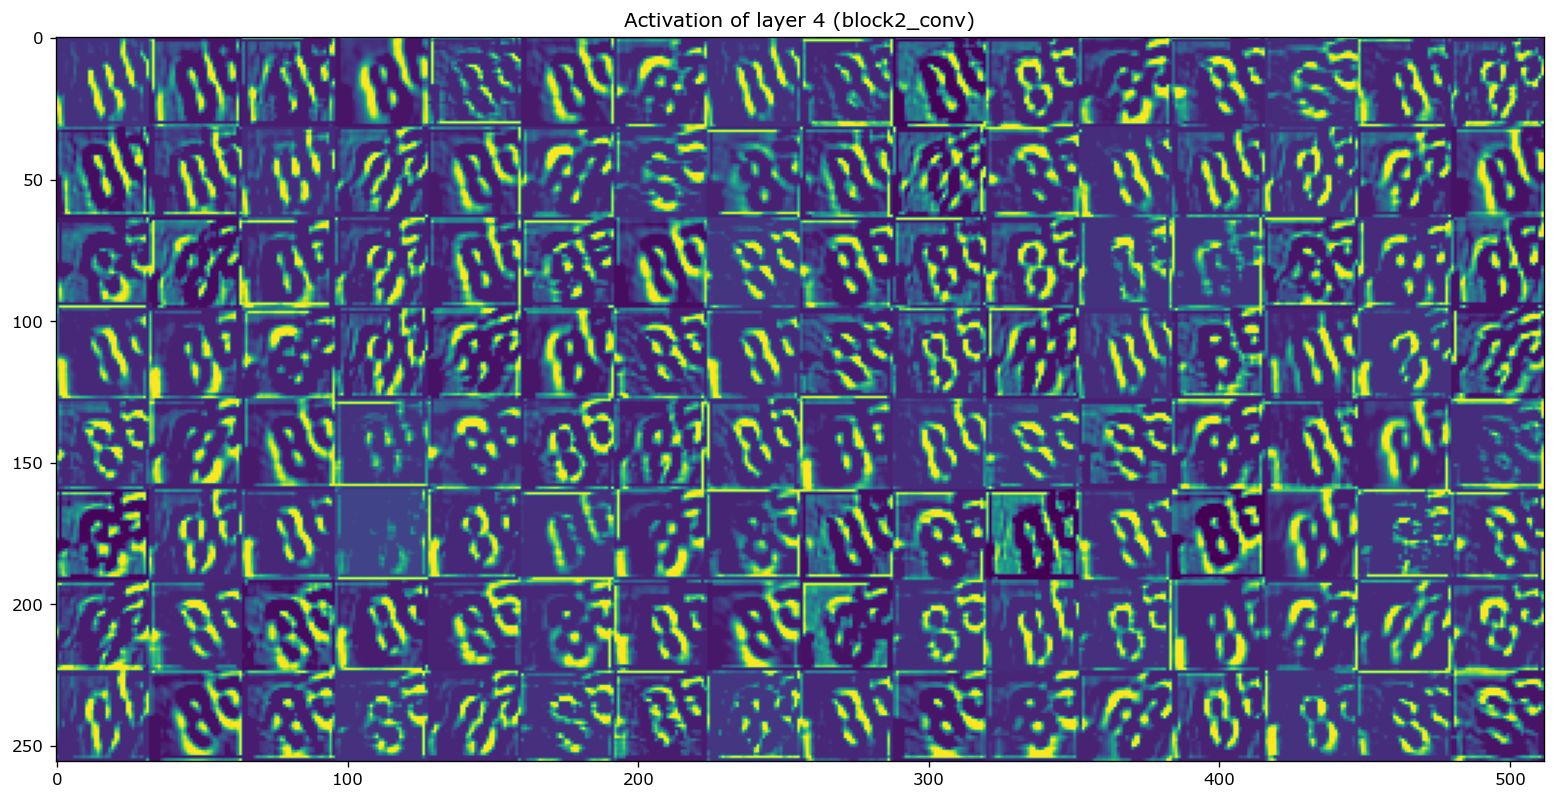

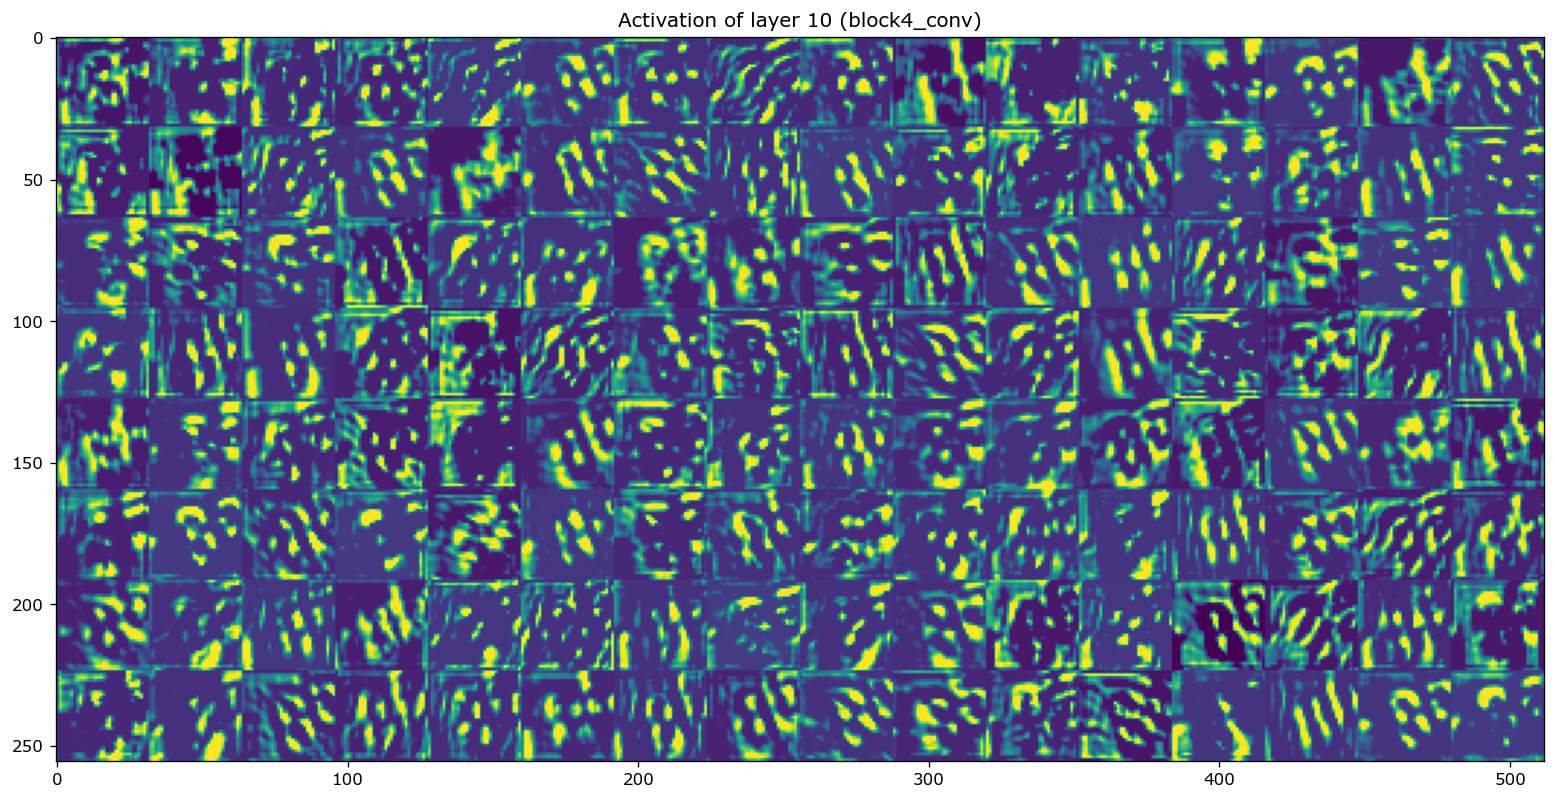

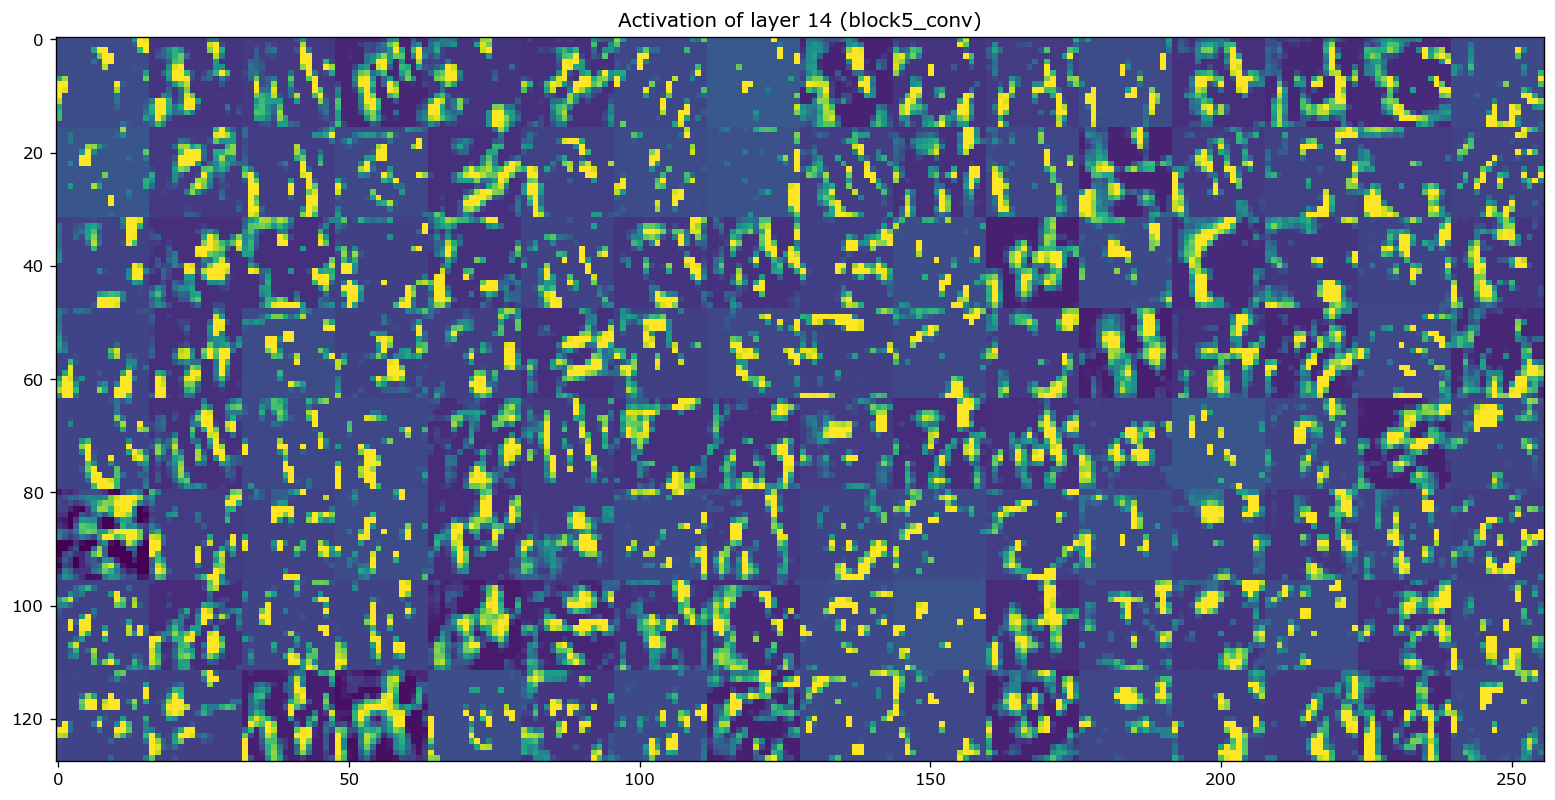

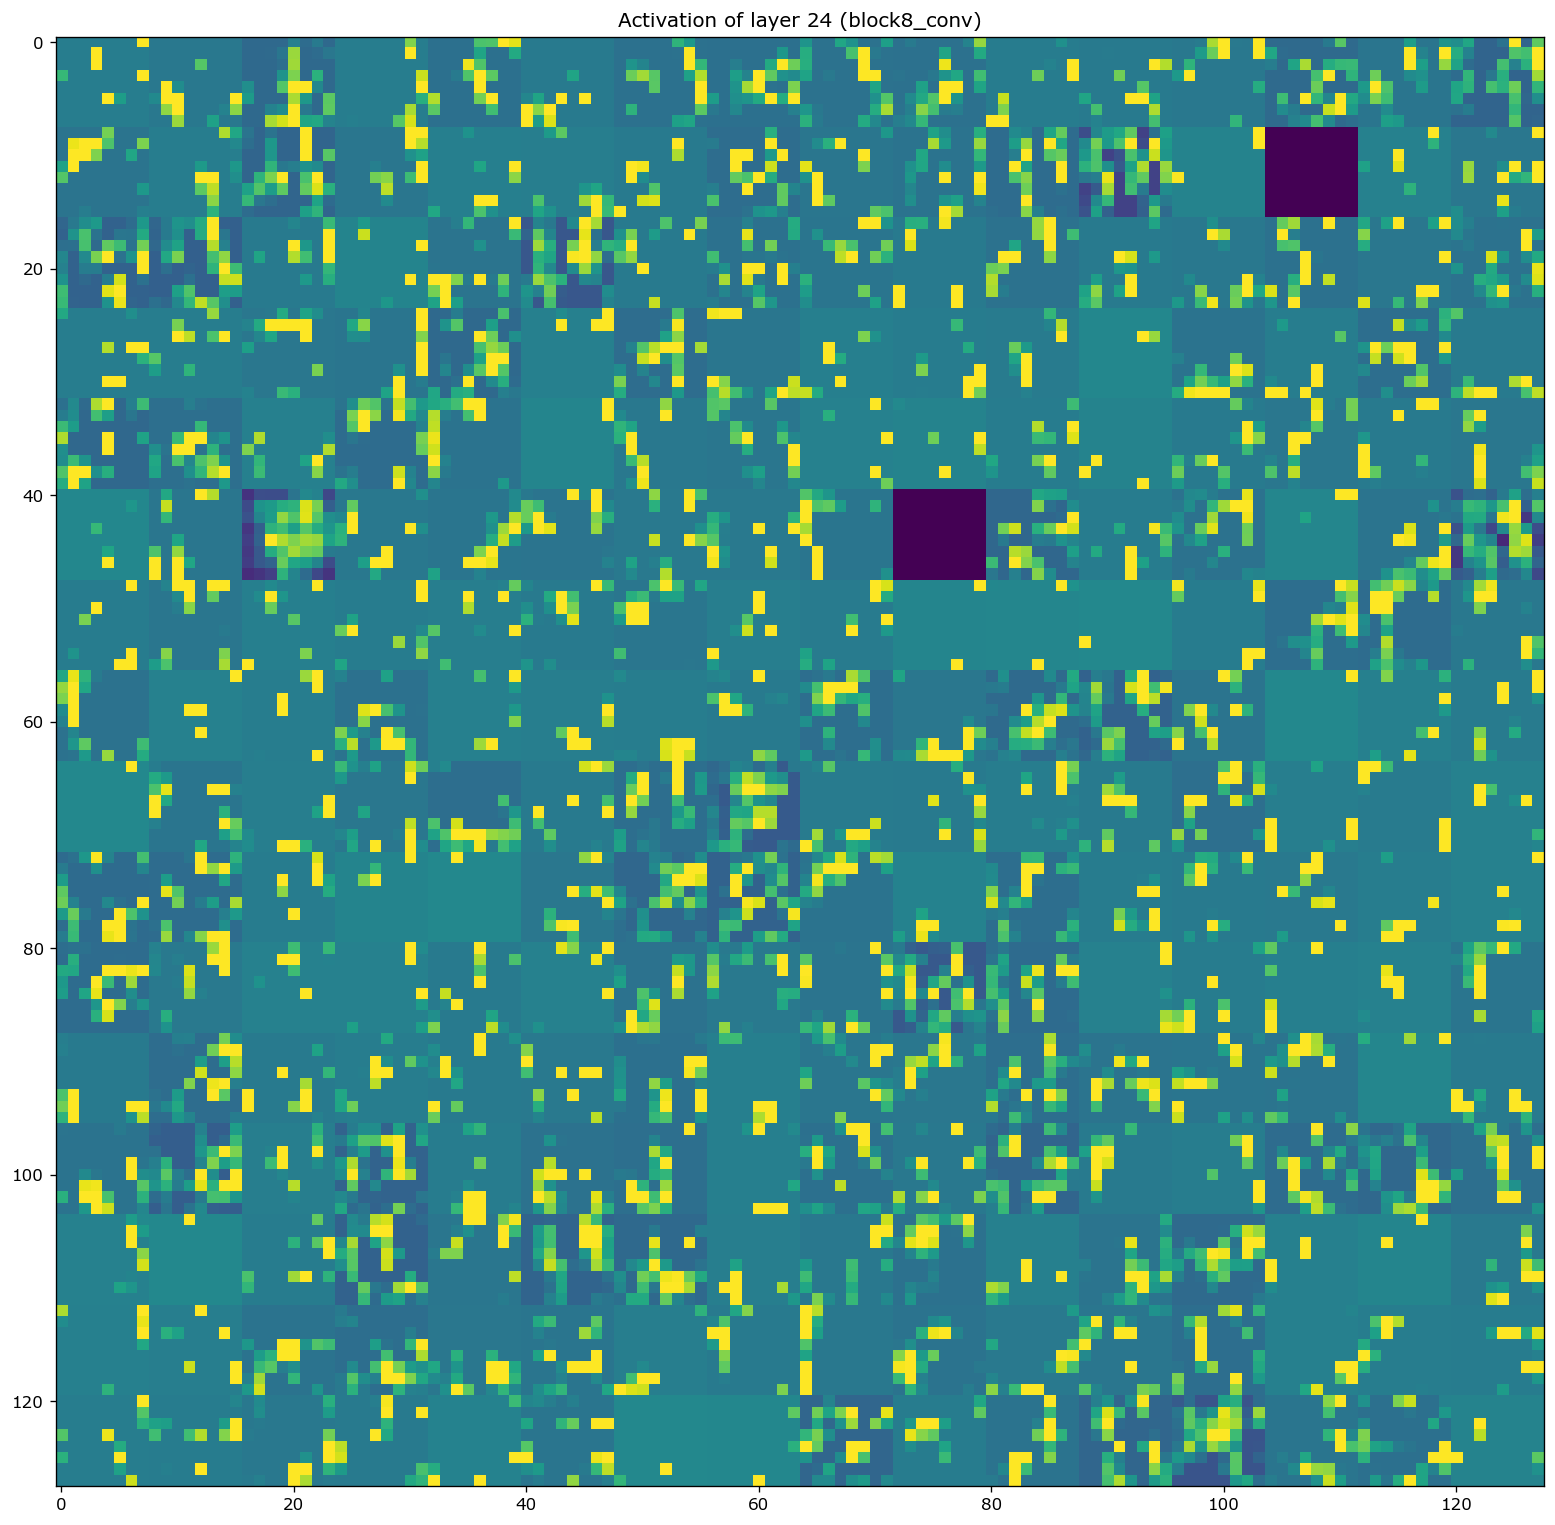

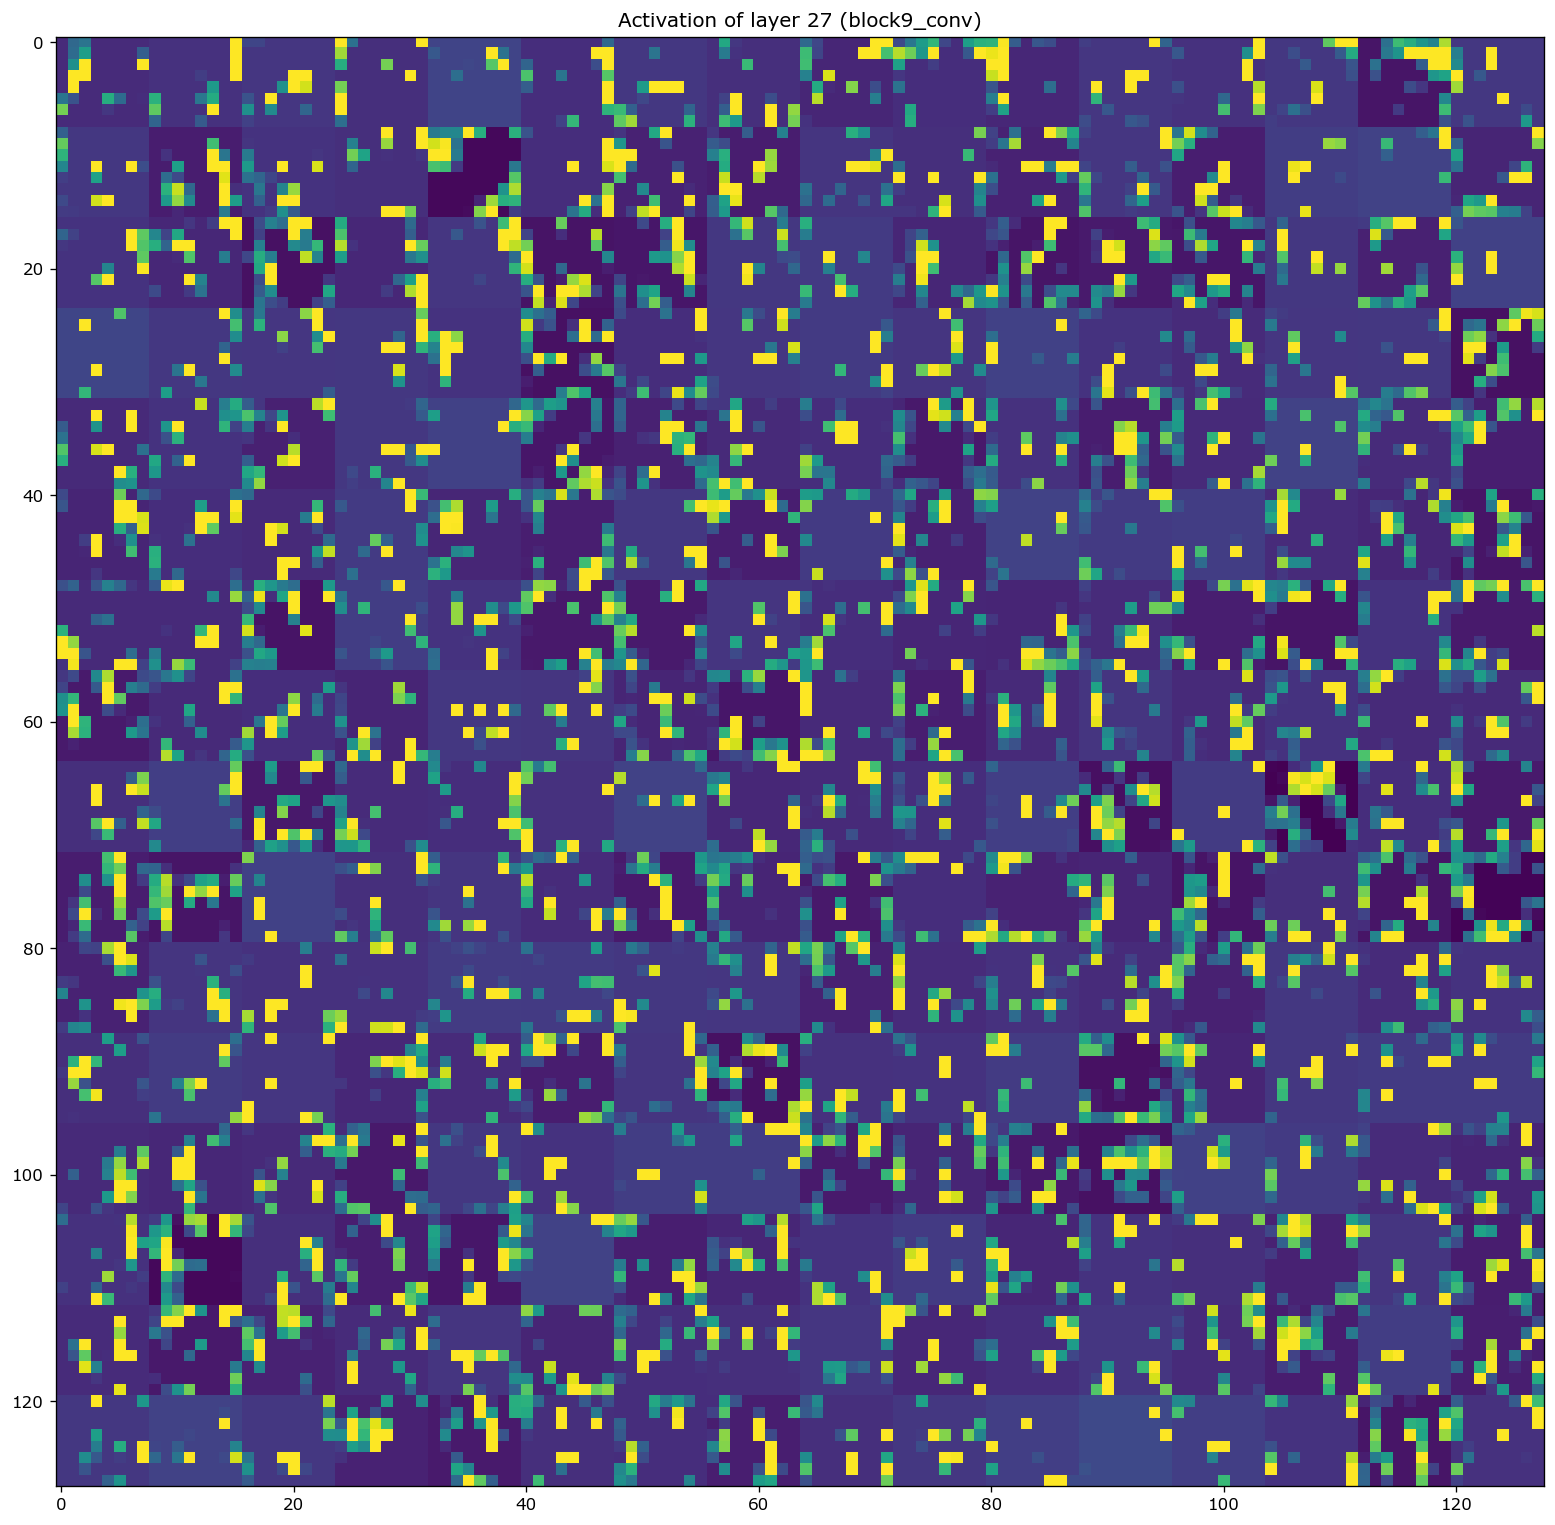

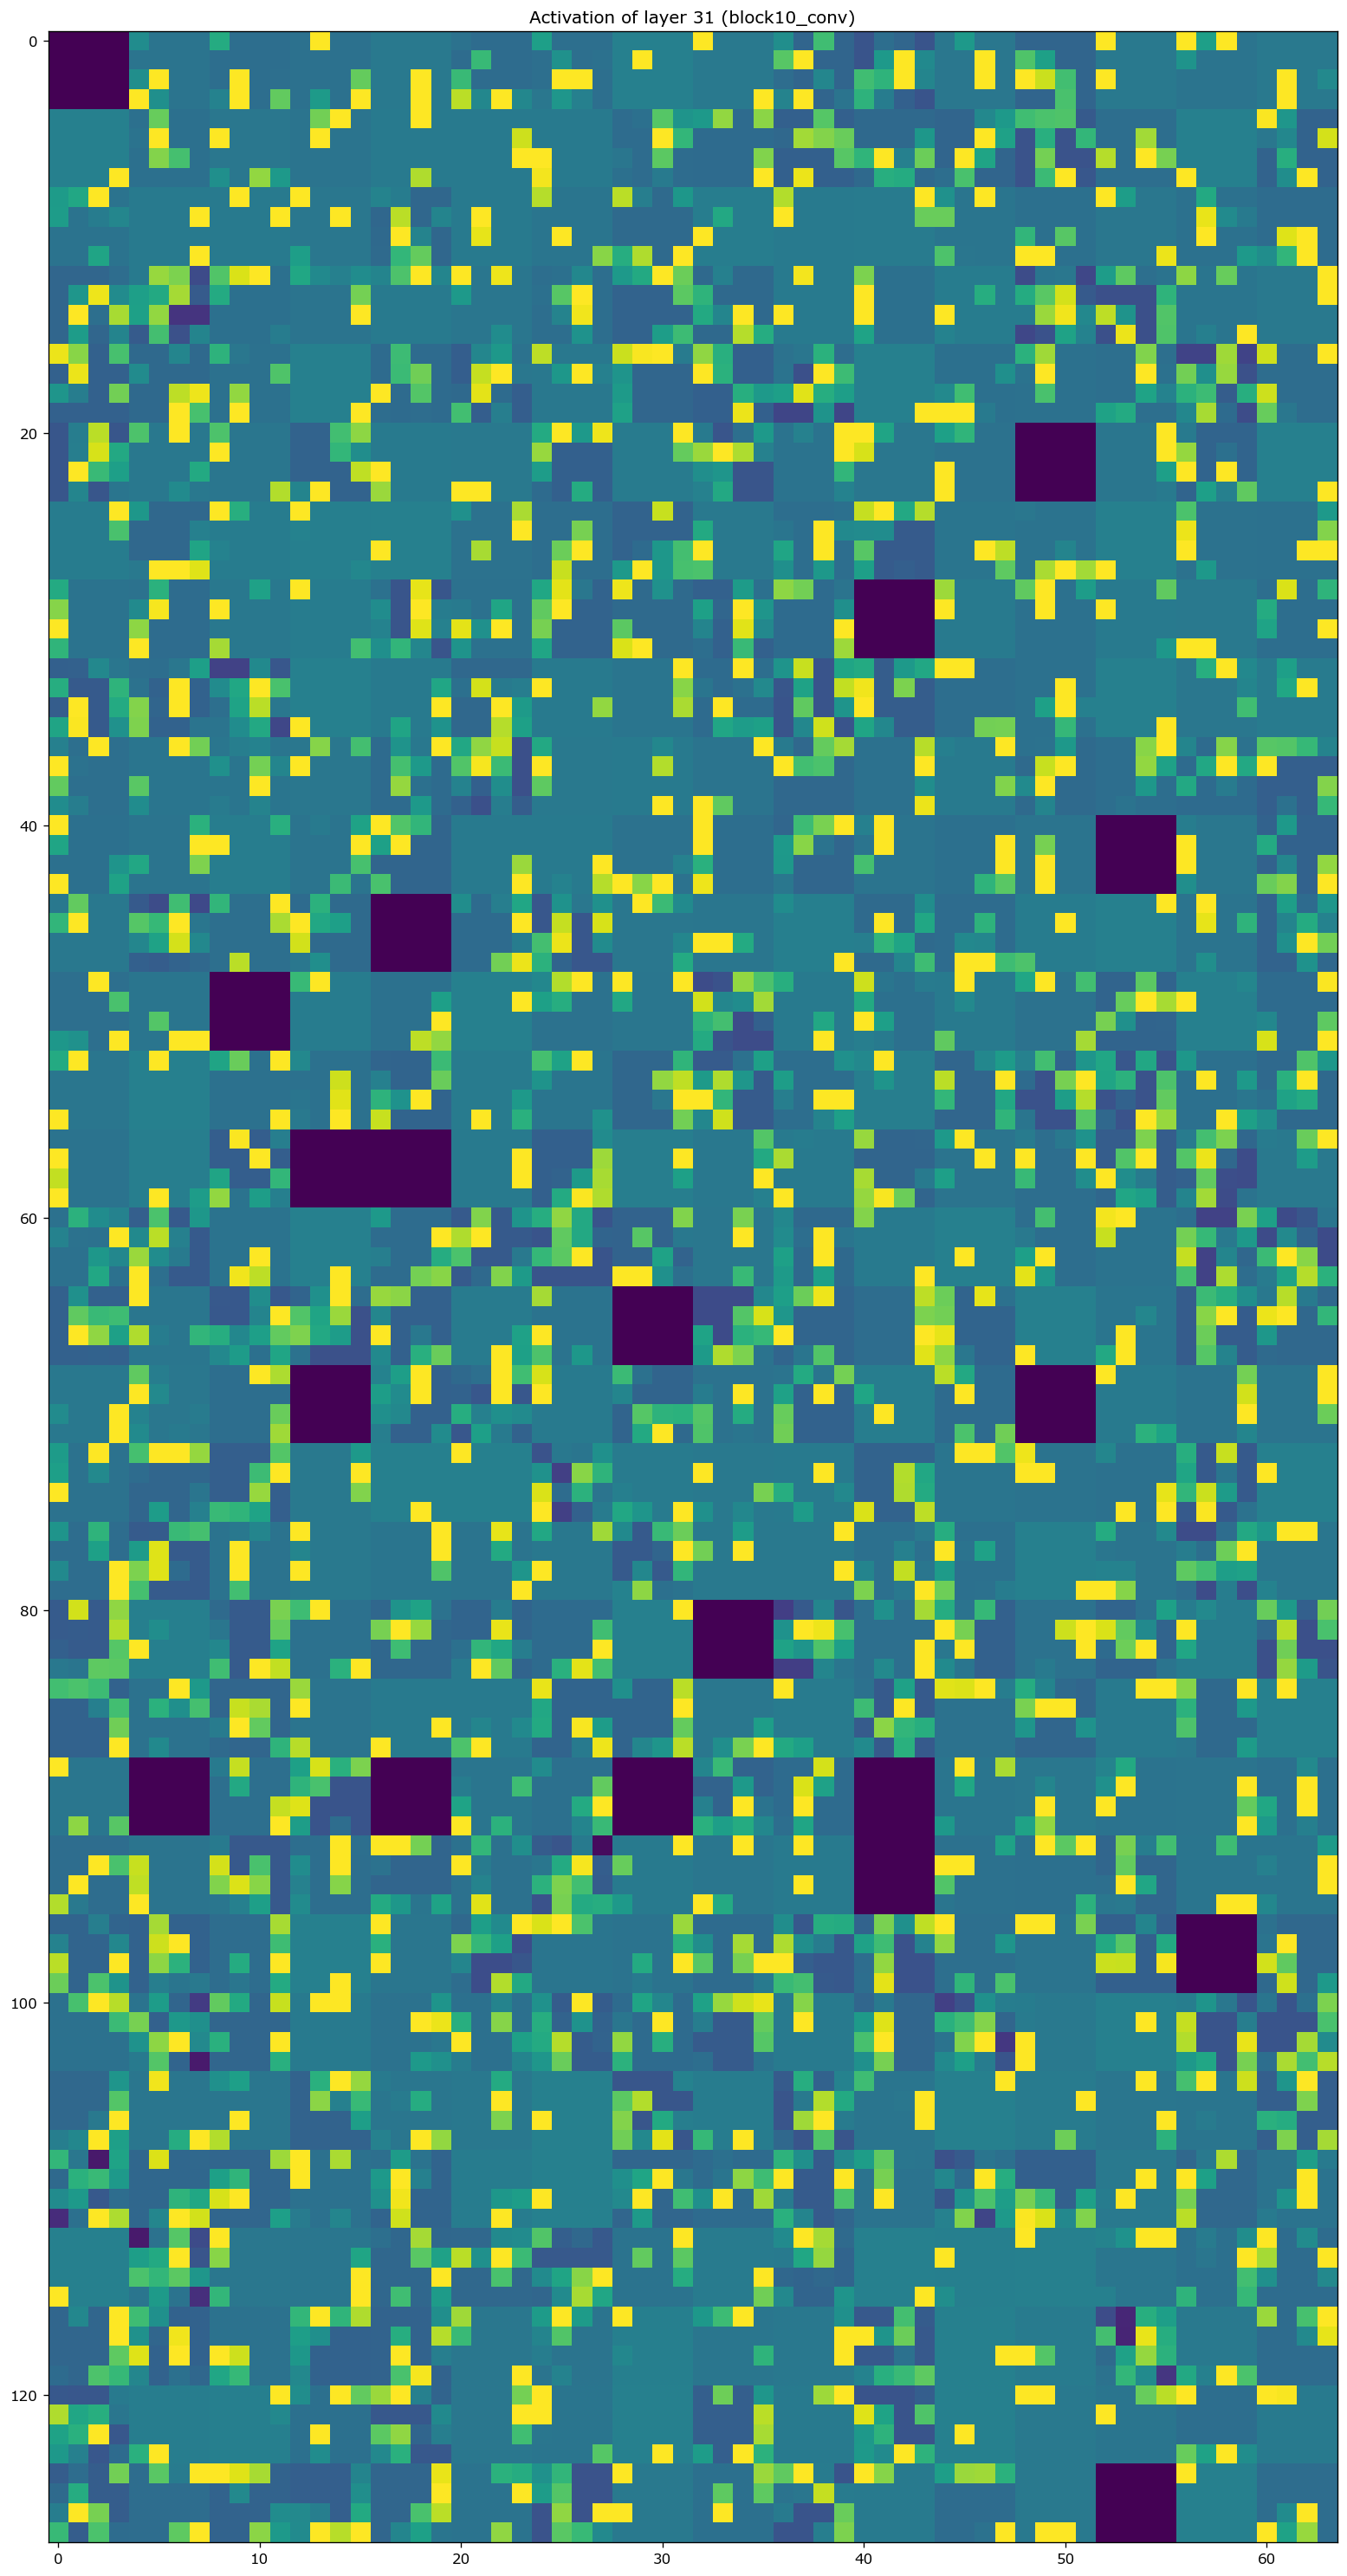

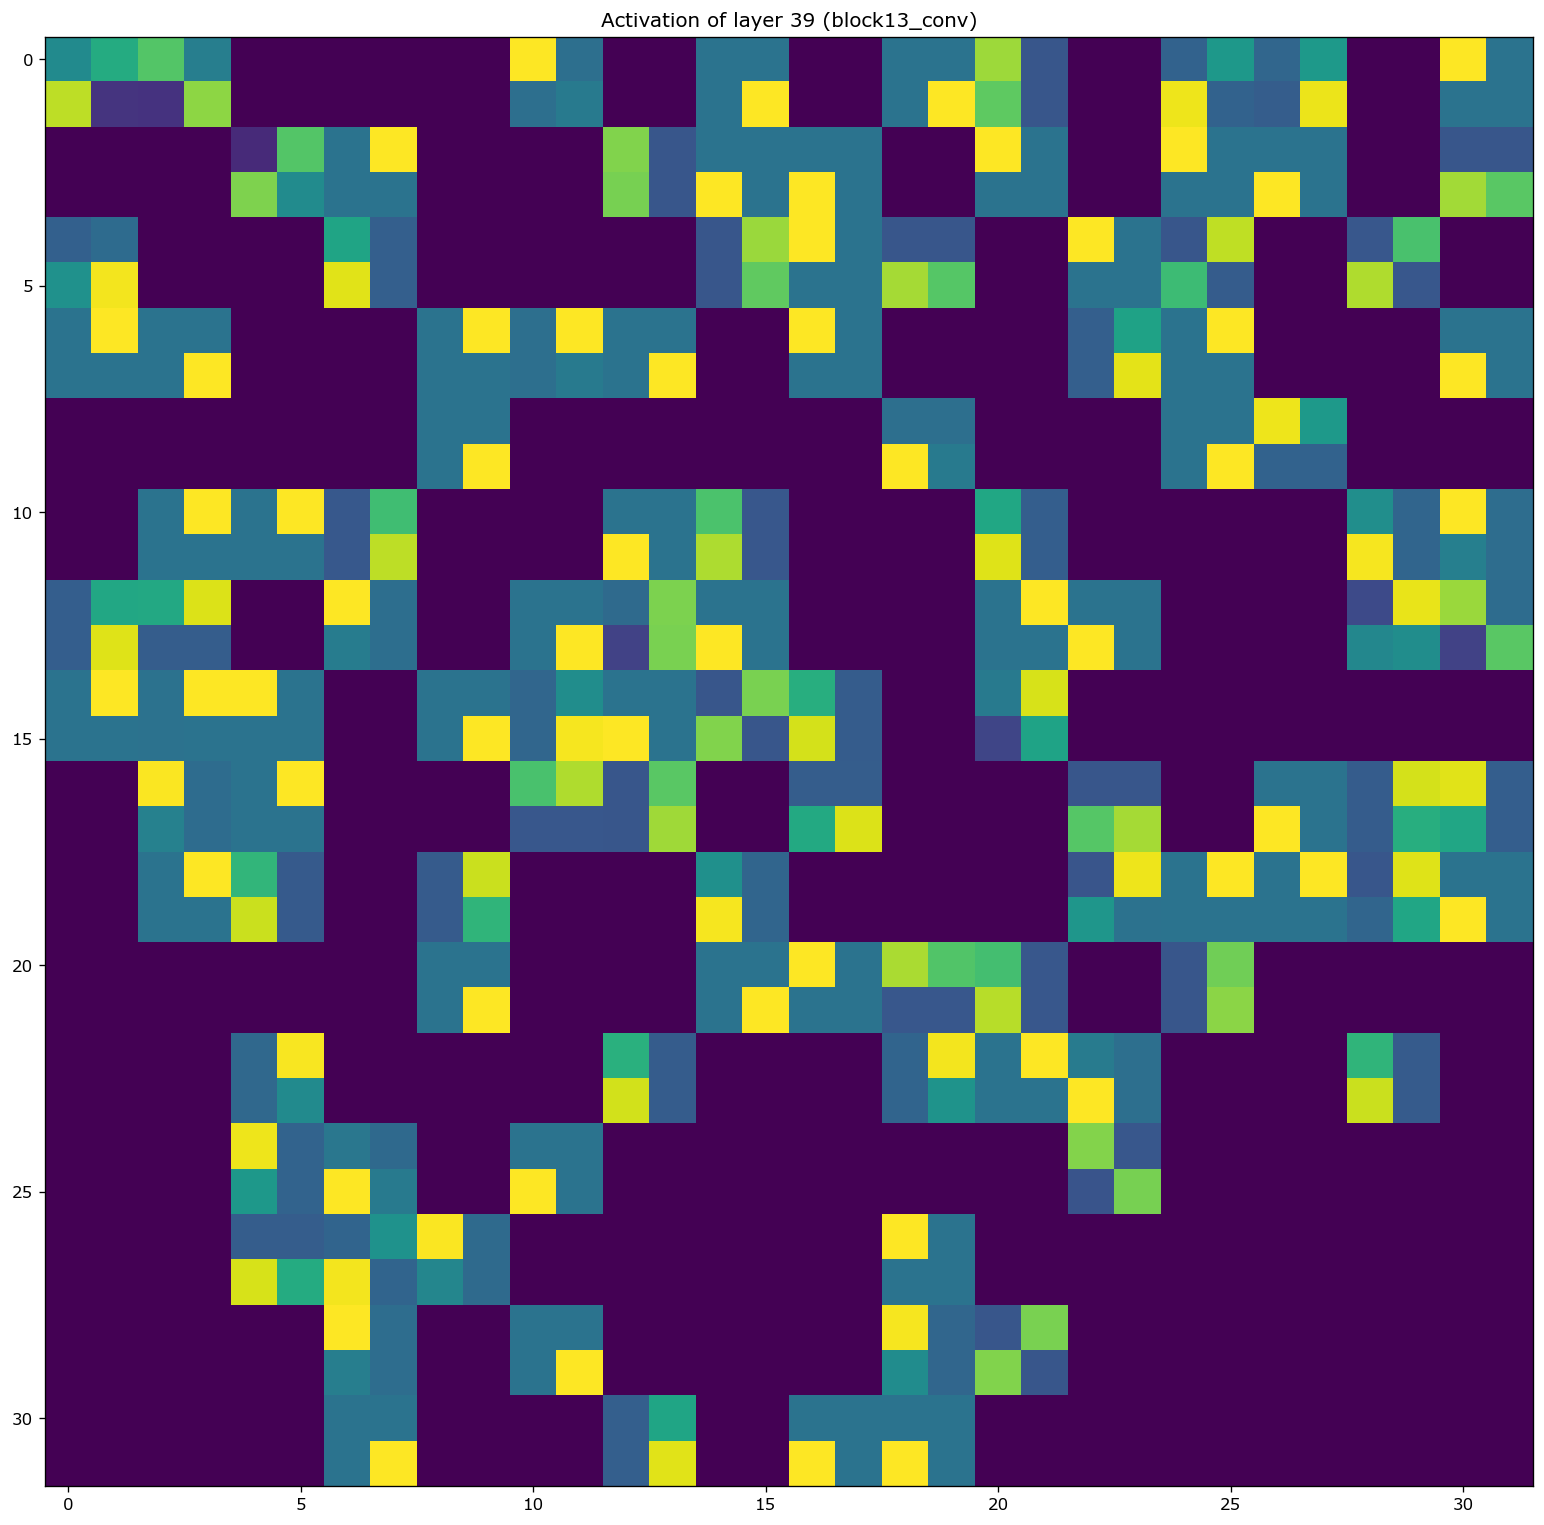

In [55]:
def plot_activations():
    for idx in [0, 3, 9, 13, 23, 26, 30, 38]:
        show_filters(idx, activations)
        
# plot the activations
plot_activations()

In [56]:
answer_q_3_2 = """
We plotted the activations of 8 convolutional layers located at different depths in the network. These
8 plots give an idea of the types of features that get extracted from the input image. In the first few
layers these features are quite understandable such as edges and shapes. But deeper down the network
the features become more abstract. Note that the model also has two conv layers with 1x1 filters.
These filters were not very interesting to show as they would be shown as single squares.
"""

print("Answer is {} characters long".format(len(answer_q_3_2)))

Answer is 497 characters long


### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


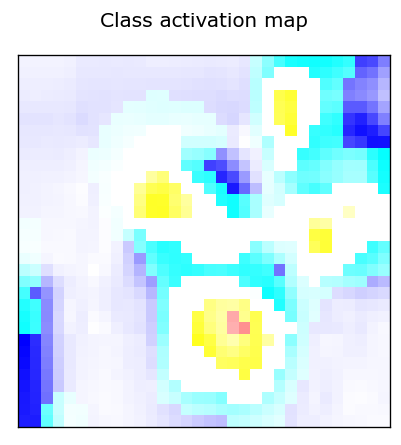

In [57]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import cv2

def plot_3_3():
    tf.compat.v1.disable_eager_execution()
    
    # load model
    model = load_model_from_file(base_dir, "model_2_2")

    # take first example of test set and prepare for function
    img_tensor = np.copy(X_test_contrast[0])
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    class_8_output = model.output[:, 7]

    # get last layer
    last_conv_layer = model.get_layer('block7_conv')
    grads = K.gradients(class_8_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

    for i in range(len(pooled_grads_value)):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)

    # Load the original image in grey scale
    img = np.copy(X_test_contrast[0])

    # Resizing of heatmap to size original image and converting to greyscale 
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img
    
    # convert to float 32
    img_conv = superimposed_img.astype('float32')
    RGB_im = cv2.cvtColor(img_conv, cv2.COLOR_BGR2RGB)
    plt.rcParams['figure.dpi'] = 120
    plt.imshow(RGB_im)
    plt.title('Class activation map')
    plt.xticks([])         
    plt.yticks([])
    plt.show()
    
    
# show the heatmap
plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

In [58]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

# VGG pre-processing
def preprocess_vgg(X):
    img = np.copy(X)
    img = img * 255.
    img = preprocess_input(img)
    img = img / 255.
    return img

# pre-process images using the specific VGG pre-processing steps
X_train_vgg = np.array([preprocess_vgg(img) for img in X_train])
X_valid_vgg = np.array([preprocess_vgg(img) for img in X_val])
X_test_vgg = np.array([preprocess_vgg(img) for img in X_test])

# make data split for VGG16
vgg16_split = X_train_vgg, X_valid_vgg, y_train, y_val

Not-trainable: input_1
Not-trainable: block1_conv1
Not-trainable: block1_conv2
Not-trainable: block1_pool
Not-trainable: block2_conv1
Not-trainable: block2_conv2
Not-trainable: block2_pool
Trainable: block3_conv1
Trainable: block3_conv2
Trainable: block3_conv3
Trainable: block3_pool
Trainable: block4_conv1
Trainable: block4_conv2
Trainable: block4_conv3
Trainable: block4_pool
Trainable: block5_conv1
Trainable: block5_conv2
Trainable: block5_conv3
Trainable: block5_pool
Trainable: block6_flatten
Trainable: block6_dropout1
Trainable: block6_fc1
Trainable: block6_dropout2
Trainable: block6_fc2
Loading model from file
Success!
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
______________________

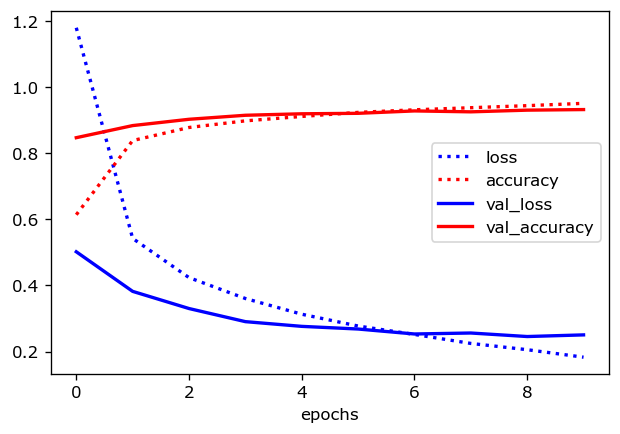

In [59]:
def build_model_4_1():
    # import the VGG16 base
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    
    # add dense layer
    x = base_model.output
    x = layers.Flatten(name='block6_flatten')(x)
    x = layers.Dropout(0.4, name='block6_dropout1')(x)
    x = layers.Dense(128, activation='relu', name='block6_fc1', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.4, name='block6_dropout2')(x)
    predictions = layers.Dense(10, activation='softmax', name='block6_fc2')(x)
    
    # define model input and output
    model = models.Model(inputs=base_model.input, outputs=predictions)

    # freeze some layers
    for i, layer in enumerate(model.layers):
        if i <= 6:
            layer.trainable = False
            print(f'Not-trainable: {layer.name}')
        else:
            layer.trainable = True
            print(f'Trainable: {layer.name}')
    
    # compile model
    adam = optimizers.Adam(learning_rate=1.0e-5)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

run_evaluation("model_4_1", build_model_4_1, vgg16_split, base_dir, 
               train=False, epochs=10, batch_size=64)

In [60]:
answer_q_4_1 = """
Fully freezing the original conv base resulted in poor accuracy when retraining the model and its
embeddings would result in a low accuracy at 4.2. So, we had to finetune the base so that the
embeddings would be more useful for our data. We found that unfreezing more blocks would result in
better embeddings, but to be sure that we would not erase too much of the original embeddings,
we unfroze only the last three block of convolutions and re-trained these with a very very
small learning rate.
"""

print("Answer is {} characters long".format(len(answer_q_4_1)))

Answer is 499 characters long


### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [61]:
import pickle
import gzip

def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

In [62]:
def extract_features(network, data, labels, batch_size=128):
    sample_count = data.shape[0]
    features = np.zeros(shape=(sample_count, 1, 1, 512))
    
    generator = tf.keras.preprocessing.image.NumpyArrayIterator(
        data, 
        y=labels, 
        image_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(), 
        batch_size=batch_size, 
        shuffle=False)

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = network.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels

In [63]:
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    
    # load our fine-tuned VGG16 model
    vgg16 = load_model_from_file(base_dir, "model_4_1")
    vgg16_output = vgg16.get_layer('block5_pool').output
    vgg16_base = models.Model(inputs=vgg16.input, outputs=vgg16_output)

    # prepare correct label format
    y_train_int = np.argmax(y_train, axis=1)
    y_valid_int = np.argmax(y_val, axis=1)
    y_test_int = np.argmax(y_test, axis=1)
    
    # create embeddings for the train, valid, and test data
    train_features, train_labels = extract_features(vgg16_base, X_train, y_train)
    valid_features, valid_labels = extract_features(vgg16_base, X_val, y_val)
    test_features, test_labels = extract_features(vgg16_base, X_test, y_test)

    # reshape embeddings to one dimension
    train_features = np.reshape(train_features, (train_features.shape[0], 1 * 1 * 512))
    valid_features = np.reshape(valid_features, (valid_features.shape[0], 1 * 1 * 512))
    test_features = np.reshape(test_features, (test_features.shape[0], 1 * 1 * 512))

    # save embeddings to disk
    store_embedding(train_features, 'train_features')
    store_embedding(valid_features, 'valid_features')
    store_embedding(test_features, 'test_features')
    

# store the embeddings
store_embeddings()

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    
    # initialize k-nearest neighbors
    clf = KNeighborsClassifier(
        n_neighbors=15, 
        n_jobs=-1)
    
    # initialize random forest
    rfc = RandomForestClassifier(
        n_estimators=2000, 
        criterion='gini', 
        max_depth=None, 
        min_samples_split=20, 
        min_samples_leaf=10, 
        min_weight_fraction_leaf=0.0, 
        max_features='auto', 
        max_leaf_nodes=None, 
        bootstrap=True, 
        oob_score=True, 
        n_jobs=-1, 
        random_state=None, 
        verbose=1)
    
    # making a pipeline with gradient boosting classifier
    pipeline = Pipeline(steps=[('classifier', clf)])
    
    return pipeline

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_validate


def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
    evaluated on the supplied embedded test set. Returns the accuracy score.
    """
    
    # set up cross-validation scheme
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    use_cv = False
    if use_cv:
        # train and evaluate pipeline using cross-validation
        cv_score = np.mean(cross_validate(pipeline, X_train, y_train, scoring='accuracy', cv=kf, verbose=1)['test_score'])
        print(f'Accuracy of cross-validation: {round(score, 4)}')
    
    # train pipeline using full data
    pipeline.fit(X_train, y_train)
    
    # evaluate on test set and calculate accuracy
    score = pipeline.score(X_test, y_test)
    
    return score

In [66]:
def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    
    # prepare correct label format
    y_train_int = np.argmax(y_train, axis=1)
    y_valid_int = np.argmax(y_val, axis=1)
    y_test_int = np.argmax(y_test, axis=1)
    
    # load the embeddings from disk
    train_features = load_embedding('train_features')
    valid_features = load_embedding('valid_features')
    test_features = load_embedding('test_features')
    
    # load the pipeline
    pipeline = generate_pipeline()
    
    # evaluate the pipeline on validation data
    score_valid = evaluate_pipeline(pipeline, train_features, y_train_int, valid_features, y_valid_int)
    print(f'Accuracy on validation set: {round(score_valid, 4)}')
    
    # evaluate pipeline on the test data
    score_test = evaluate_pipeline(pipeline, train_features, y_train_int, test_features, y_test_int)
    print(f'Accuracy on test set: {round(score_test, 4)}')
    
    return score_test

In [67]:
# evaluate the classifier using the embeddings
evaluation_4_2(X_train, y_train, X_test, y_test)

Accuracy on validation set: 0.9275
Accuracy on test set: 0.9268


0.9267801389868063

In [68]:
answer_q_4_2 = """
In 4.1 we slightly fine-tuned the original embeddings by training the network with the last few block of
convolutions unfrozen. We then implemented a simple kNN classifier that achieved a decent test accuracy
of 92.7%. This accuracy is not better than our current best model, which is the CNN of 2.2 with 96.6% 
accuracy. However, it is impressive how with only a small amount of fine-tuning the VGG16 embeddings 
perform in combination with a simple classification algorithm such as kNN.
"""

print("Pipeline:", generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Pipeline: Pipeline(memory=None,
         steps=[('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=15, p=2,
                                      weights='uniform'))],
         verbose=False)
Answer is 490 characters long
